<a href="https://colab.research.google.com/github/moamirin/amirin.github.io/blob/main/how_to_track_and_count_vehicles_with_yolov8.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!nvidia-smi

Tue Aug 29 08:27:46 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   57C    P8    13W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
import os
HOME = os.getcwd()
print(HOME)

/content


In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


## Download video

In [ ]:
# Download Video Tes
%cd {HOME}
!wget 'https://drive.usercontent.google.com/download?id=1pdk3A3q861ZTh_JYSEmbmJ5qNRBrgaYo&export=download&authuser=2&confirm=t&uuid=a3d7d6ce-dafa-4ece-b6b6-7a4273512c1d&at=APZUnTUq-6CzU73py0Zuw7ljdI0R:1693297182848'  -O video.mp4

/content
--2023-08-29 08:28:16--  https://drive.usercontent.google.com/download?id=1pdk3A3q861ZTh_JYSEmbmJ5qNRBrgaYo&export=download&authuser=2&confirm=t&uuid=a3d7d6ce-dafa-4ece-b6b6-7a4273512c1d&at=APZUnTUq-6CzU73py0Zuw7ljdI0R:1693297182848
Resolving drive.usercontent.google.com (drive.usercontent.google.com)... 74.125.130.132, 2404:6800:4003:c01::84
Connecting to drive.usercontent.google.com (drive.usercontent.google.com)|74.125.130.132|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 12588306 (12M) [video/mp4]
Saving to: ‘video.mp4’

video.mp4           100%[===================>]  12.00M  --.-KB/s    in 0.1s    

2023-08-29 08:28:18 (121 MB/s) - ‘video.mp4’ saved [12588306/12588306]



In [ ]:
# Download Model
%cd {HOME}
!wget 'https://drive.usercontent.google.com/download?id=1cxIZcBWVszi18Uj6CdXy6eqfZaiKiKpq&export=download&authuser=2&confirm=t&uuid=641220ac-8db8-46ab-bf9a-a57550283b4b&at=APZUnTUPfPcVc4tEQ7EMUsZHVddf:1693273078308'  -O best.pt

/content
--2023-08-29 08:28:18--  https://drive.usercontent.google.com/download?id=1cxIZcBWVszi18Uj6CdXy6eqfZaiKiKpq&export=download&authuser=2&confirm=t&uuid=641220ac-8db8-46ab-bf9a-a57550283b4b&at=APZUnTUPfPcVc4tEQ7EMUsZHVddf:1693273078308
Resolving drive.usercontent.google.com (drive.usercontent.google.com)... 74.125.130.132, 2404:6800:4003:c01::84
Connecting to drive.usercontent.google.com (drive.usercontent.google.com)|74.125.130.132|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 22537720 (21M) [application/octet-stream]
Saving to: ‘best.pt’

best.pt             100%[===================>]  21.49M   120MB/s    in 0.2s    

2023-08-29 08:28:21 (120 MB/s) - ‘best.pt’ saved [22537720/22537720]



In [ ]:
SOURCE_VIDEO_PATH = f"{HOME}/video.mp4"

## Install YOLOv8

⚠️ YOLOv8 is still under heavy development. Breaking changes are being introduced almost weekly. We strive to make our YOLOv8 notebooks work with the latest version of the library. Last tests took place on **23.01.2023** with version **YOLOv8.0.17**.

If you notice that our notebook behaves incorrectly - especially if you experience errors that prevent you from going through the tutorial - don't hesitate! Let us know and open an [issue](https://github.com/roboflow/notebooks/issues) on the Roboflow Notebooks repository.

In [ ]:
# Pip install method (recommended)

!pip install ultralytics

from IPython import display
display.clear_output()

import ultralytics
ultralytics.checks()

Ultralytics YOLOv8.0.165 🚀 Python-3.10.12 torch-2.0.1+cu118 CUDA:0 (Tesla T4, 15102MiB)
Setup complete ✅ (2 CPUs, 12.7 GB RAM, 26.3/78.2 GB disk)


## Install ByteTrack

[ByteTrack](https://github.com/ifzhang/ByteTrack) is great tracker but a bit poorly packaged. We need to jump through some fire hoops to make it work in tandem with [YOLOv8](https://github.com/ultralytics/ultralytics).

In [ ]:
%cd {HOME}
!git clone https://github.com/ifzhang/ByteTrack.git
%cd {HOME}/ByteTrack

# workaround related to https://github.com/roboflow/notebooks/issues/80
!sed -i 's/onnx==1.8.1/onnx==1.9.0/g' requirements.txt

!pip3 install -q -r requirements.txt
!python3 setup.py -q develop
!pip install -q cython_bbox
!pip install -q onemetric
# workaround related to https://github.com/roboflow/notebooks/issues/112 and https://github.com/roboflow/notebooks/issues/106
!pip install -q loguru lap thop

from IPython import display
display.clear_output()


import sys
sys.path.append(f"{HOME}/ByteTrack")


import yolox
print("yolox.__version__:", yolox.__version__)

yolox.__version__: 0.1.0


In [ ]:
from yolox.tracker.byte_tracker import BYTETracker, STrack
from onemetric.cv.utils.iou import box_iou_batch
from dataclasses import dataclass


@dataclass(frozen=True)
class BYTETrackerArgs:
    track_thresh: float = 0.25
    track_buffer: int = 30
    match_thresh: float = 0.8
    aspect_ratio_thresh: float = 3.0
    min_box_area: float = 1.0
    mot20: bool = False

## Install Roboflow Supervision

In [ ]:
!pip install supervision==0.1.0


from IPython import display
display.clear_output()


import supervision

print("supervision.__version__:", supervision.__version__)

supervision.__version__: 0.1.0


In [ ]:
from supervision.draw.color import ColorPalette
from supervision.geometry.dataclasses import Point
from supervision.video.dataclasses import VideoInfo
from supervision.video.source import get_video_frames_generator
from supervision.video.sink import VideoSink
from supervision.notebook.utils import show_frame_in_notebook
from supervision.tools.detections import Detections, BoxAnnotator
from supervision.tools.line_counter import LineCounter, LineCounterAnnotator

## Tracking utils

Unfortunately, we have to manually match the bounding boxes coming from our model with those created by the tracker.

In [ ]:
from typing import List

import numpy as np


# converts Detections into format that can be consumed by match_detections_with_tracks function
def detections2boxes(detections: Detections) -> np.ndarray:
    return np.hstack((
        detections.xyxy,
        detections.confidence[:, np.newaxis]
    ))


# converts List[STrack] into format that can be consumed by match_detections_with_tracks function
def tracks2boxes(tracks: List[STrack]) -> np.ndarray:
    return np.array([
        track.tlbr
        for track
        in tracks
    ], dtype=float)


# matches our bounding boxes with predictions
def match_detections_with_tracks(
    detections: Detections,
    tracks: List[STrack]
) -> Detections:
    if not np.any(detections.xyxy) or len(tracks) == 0:
        return np.empty((0,))

    tracks_boxes = tracks2boxes(tracks=tracks)
    iou = box_iou_batch(tracks_boxes, detections.xyxy)
    track2detection = np.argmax(iou, axis=1)

    tracker_ids = [None] * len(detections)

    for tracker_index, detection_index in enumerate(track2detection):
        if iou[tracker_index, detection_index] != 0:
            tracker_ids[detection_index] = tracks[tracker_index].track_id

    return tracker_ids

## Load pre-trained YOLOv8 model

In [ ]:
# settings
MODEL =  f"{HOME}/best.pt"

In [ ]:
from ultralytics import YOLO

model = YOLO(MODEL)
model.fuse()

Model summary (fused): 168 layers, 11125971 parameters, 0 gradients


## Predict and annotate single frame

In [ ]:
# dict maping class_id to class_name
CLASS_NAMES_DICT = model.model.names
# class_ids of interest
CLASS_ID = [0]


0: 480x800 1 Tumpal-Sarung, 305.2ms
Speed: 21.9ms preprocess, 305.2ms inference, 30.3ms postprocess per image at shape (1, 3, 480, 800)


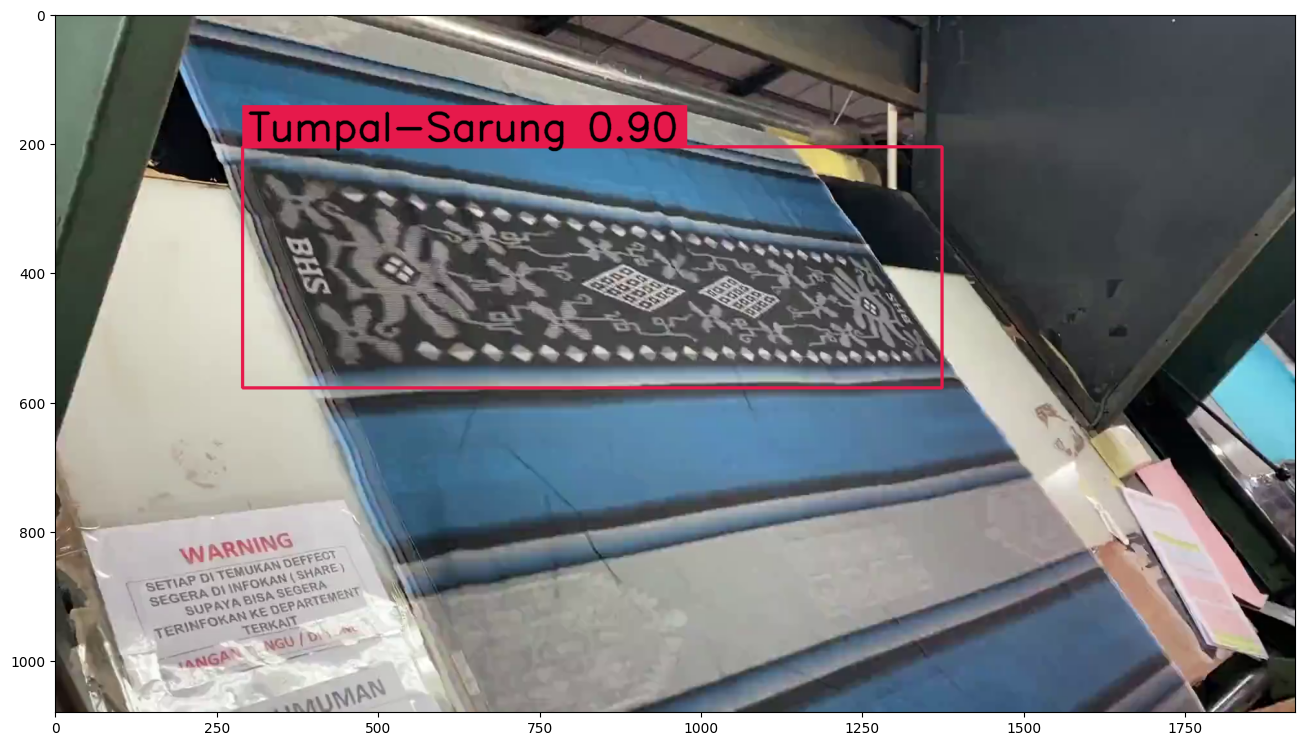

In [ ]:
# create frame generator
generator = get_video_frames_generator(SOURCE_VIDEO_PATH)
# create instance of BoxAnnotator
box_annotator = BoxAnnotator(color=ColorPalette(), thickness=4, text_thickness=4, text_scale=2)
# acquire first video frame
iterator = iter(generator)
frame = next(iterator)
# model prediction on single frame and conversion to supervision Detections
results = model(frame)
detections = Detections(
    xyxy=results[0].boxes.xyxy.cpu().numpy(),
    confidence=results[0].boxes.conf.cpu().numpy(),
    class_id=results[0].boxes.cls.cpu().numpy().astype(int)
)
# format custom labels
labels = [
    f"{CLASS_NAMES_DICT[class_id]} {confidence:0.2f}"
    for _, confidence, class_id, tracker_id
    in detections
]
# annotate and display frame
frame = box_annotator.annotate(frame=frame, detections=detections, labels=labels)

%matplotlib inline
show_frame_in_notebook(frame, (16, 16))

## Predict and annotate whole video

In [ ]:
# settings
LINE_START = Point(0, 450)
LINE_END = Point(1900, 450)

TARGET_VIDEO_PATH = f"{HOME}/IMG_2950-result4.mp4"

In [ ]:
VideoInfo.from_video_path(SOURCE_VIDEO_PATH)

VideoInfo(width=1920, height=1080, fps=59, total_frames=4368)

In [ ]:
from tqdm.notebook import tqdm
import cv2


text_color = (0, 0, 0)  # Warna teks hitam (BGR)
background_color = (255, 255, 255)  # Warna latar belakang putih (BGR)

# create BYTETracker instance
byte_tracker = BYTETracker(BYTETrackerArgs())
# create VideoInfo instance
video_info = VideoInfo.from_video_path(SOURCE_VIDEO_PATH)
# create frame generator
generator = get_video_frames_generator(SOURCE_VIDEO_PATH)
# create LineCounter instance
line_counter = LineCounter(start=LINE_START, end=LINE_END)
# create instance of BoxAnnotator and LineCounterAnnotator
box_annotator = BoxAnnotator(color=ColorPalette(), thickness=4, text_thickness=4, text_scale=2)
line_annotator = LineCounterAnnotator(thickness=4, text_thickness=4, text_scale=2)


# open target video file
with VideoSink(TARGET_VIDEO_PATH, video_info) as sink:
    # loop over video frames
    for frame in tqdm(generator, total=video_info.total_frames):
        # model prediction on single frame and conversion to supervision Detections
        results = model(frame)
        detections = Detections(
            xyxy=results[0].boxes.xyxy.cpu().numpy(),
            confidence=results[0].boxes.conf.cpu().numpy(),
            class_id=results[0].boxes.cls.cpu().numpy().astype(int)
        )
        # filtering out detections with unwanted classes
        mask = np.array([class_id in CLASS_ID for class_id in detections.class_id], dtype=bool)
        detections.filter(mask=mask, inplace=True)
        # tracking detections
        tracks = byte_tracker.update(
            output_results=detections2boxes(detections=detections),
            img_info=frame.shape,
            img_size=frame.shape
        )
        tracker_id = match_detections_with_tracks(detections=detections, tracks=tracks)
        detections.tracker_id = np.array(tracker_id)
        # filtering out detections without trackers
        mask = np.array([tracker_id is not None for tracker_id in detections.tracker_id], dtype=bool)
        detections.filter(mask=mask, inplace=True)
        # format custom labels
        labels = [
            f"#{tracker_id} {CLASS_NAMES_DICT[class_id]} {confidence:0.2f}"
            for _, confidence, class_id, tracker_id
            in detections
        ]
        # updating line counter
        line_counter.update(detections=detections)

        jumlah = line_counter.in_count - line_counter.out_count
        text = f"Jumlah Sarung: {jumlah}"
        text_size = cv2.getTextSize(text, cv2.FONT_HERSHEY_SIMPLEX, 2, 3)[0]
        text_x = 15
        text_y = 50

        cv2.rectangle(frame, (text_x, text_y - text_size[1] - 5),
                      (text_x + text_size[0], text_y + 5), background_color, -1)
        cv2.putText(frame, text, (text_x, text_y), cv2.FONT_HERSHEY_SIMPLEX, 2, text_color, 3)

        # annotate and display frame
        frame = box_annotator.annotate(frame=frame, detections=detections, labels=labels)
        line_annotator.annotate(frame=frame, line_counter=line_counter)
        sink.write_frame(frame)

  0%|          | 0/4368 [00:00<?, ?it/s]

Output streaming akan dipotong hingga 5000 baris terakhir.
0: 480x800 1 Tumpal-Sarung, 15.5ms
Speed: 4.1ms preprocess, 15.5ms inference, 1.9ms postprocess per image at shape (1, 3, 480, 800)

0: 480x800 1 Tumpal-Sarung, 16.7ms
Speed: 4.9ms preprocess, 16.7ms inference, 1.7ms postprocess per image at shape (1, 3, 480, 800)

0: 480x800 1 Tumpal-Sarung, 15.5ms
Speed: 4.9ms preprocess, 15.5ms inference, 1.9ms postprocess per image at shape (1, 3, 480, 800)

0: 480x800 1 Tumpal-Sarung, 15.6ms
Speed: 5.2ms preprocess, 15.6ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 800)

0: 480x800 1 Tumpal-Sarung, 15.5ms
Speed: 5.8ms preprocess, 15.5ms inference, 1.9ms postprocess per image at shape (1, 3, 480, 800)

0: 480x800 1 Tumpal-Sarung, 15.7ms
Speed: 4.7ms preprocess, 15.7ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 800)

0: 480x800 1 Tumpal-Sarung, 15.5ms
Speed: 6.2ms preprocess, 15.5ms inference, 2.1ms postprocess per image at shape (1, 3, 480, 800)

0: 480x800

In [ ]:
!cp -r '/content/IMG_2950-result4.mp4' /content/gdrive/MyDrive/project/